# End-to-End MLOps Demo (Airbnb NYC): 9 Stages in Action

This notebook is a **polished, end-to-end MLOps walkthrough** using the **NYC Airbnb dataset** and open-source tools.

It is designed to be **assignment-ready**:
- Uses the NYC Airbnb dataset (`AB_NYC_2019.csv`)
- Provides a **9-stage MLOps narrative**
- Integrates with the provided **Metaflow pipeline** (`nyc_airbnb_flow.py`)
- Includes **deployment** (FastAPI + optional BentoML)
- Includes **monitoring** (Evidently drift report)
- Includes a **continuous retraining trigger** (simple automation logic)

> Run this notebook from the project root so relative paths work.


## Setup
Install dependencies once (run in a terminal):
```bash
pip install -r requirements.txt
```

Ensure dataset is placed at:
- `data/AB_NYC_2019.csv`


In [1]:
# import os
# import pandas as pd
# import numpy as np
# DATA_PATH = "DATA_PATH/AB_NYC_2019.csv"

# #DATA_PATH = os.environ.get("DATA_PATH", "DATA_PATH/AB_NYC_2019.csv")
# #assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}. Put your CSV there or set DATA_PATH."
# df_raw = pd.read_csv(DATA_PATH)
# df_raw.head()

import os
import pandas as pd
import numpy as np

DATA_PATH = "AB_NYC_2019.csv"
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"
df_raw = pd.read_csv(DATA_PATH)
print(df_raw.shape)
df_raw.head()


(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## STAGE 1: Business Problem & Data Understanding

**Business goal:** Predict Airbnb nightly **price** (regression).

**Success metrics:** RMSE and MAE.

**Serving-friendly feature policy:** avoid unstable/high-cardinality IDs and free-text.


In [2]:
TARGET = "price"

CAT_FEATURES = ["neighbourhood_group", "room_type"]
NUM_FEATURES = [
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "calculated_host_listings_count",
]
FEATURES = CAT_FEATURES + NUM_FEATURES

required = FEATURES + [TARGET]
missing = [c for c in required if c not in df_raw.columns]
missing

[]

## STAGE 2: Data Engineering Pipeline (Cleaning + Stable Schema)

Rules:
- Keep only `FEATURES + TARGET`
- Drop `price <= 0`
- Fill missing `reviews_per_month` with 0

**Optional DVC versioning (terminal):**
```bash
pip install dvc
dvc init --no-scm
dvc add data/AB_NYC_2019.csv
```


In [3]:
df = df_raw[required].copy()

rows_before = len(df)
df = df[df[TARGET] > 0].copy()
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

for c in NUM_FEATURES + [TARGET]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=NUM_FEATURES + [TARGET])

rows_after = len(df)

(rows_before, rows_after, rows_before - rows_after)

(48895, 48884, 11)

## STAGE 3: EDA & Experimentation

Lightweight EDA:
- Price distribution
- Mean price by neighbourhood_group and room_type


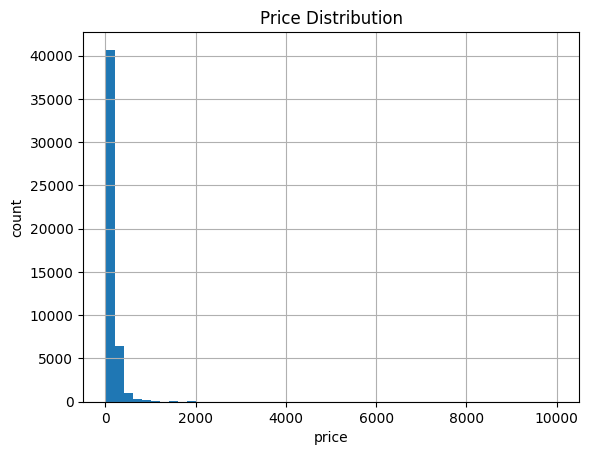

neighbourhood_group
Manhattan        196.884903
Brooklyn         124.438915
Staten Island    114.812332
Queens            99.517649
Bronx             87.577064
Name: price, dtype: float64

In [4]:
import matplotlib.pyplot as plt

plt.figure()
df[TARGET].hist(bins=50)
plt.title("Price Distribution")
plt.xlabel("price")
plt.ylabel("count")
plt.show()

df.groupby("neighbourhood_group")[TARGET].mean().sort_values(ascending=False)

In [5]:
df.groupby("room_type")[TARGET].mean().sort_values(ascending=False)

room_type
Entire home/apt    211.810918
Private room        89.809131
Shared room         70.248705
Name: price, dtype: float64

## STAGE 4: Model Development & Training (With Hyperparameter Tuning)

Train a single pipeline (preprocess + model):
- OneHotEncode categoricals
- Pass-through numerics
- RandomForestRegressor


In [6]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------------------------
# 1) Setup
# ----------------------------
TARGET = "price"

CAT_FEATURES = ["neighbourhood_group", "room_type"]
NUM_FEATURES = [
    "latitude", "longitude",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "calculated_host_listings_count",
]
FEATURES = CAT_FEATURES + NUM_FEATURES

# ----------------------------
# 2) Data + cleaning
# ----------------------------
X = df_raw[FEATURES].copy()
y = pd.to_numeric(df_raw[TARGET], errors="coerce").values

mask = np.isfinite(y) & (y > 0)
X = X.loc[mask].copy()
y = y[mask]

X["reviews_per_month"] = X["reviews_per_month"].fillna(0)
for c in NUM_FEATURES:
    X[c] = pd.to_numeric(X[c], errors="coerce")

valid = np.isfinite(X[NUM_FEATURES].values).all(axis=1)
X = X.loc[valid].copy()
y = y[valid]

# Clip outliers (keep fixed so tuning compares apples-to-apples)
cap = np.quantile(y, 0.995)
y = np.clip(y, 0, cap)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------
# 3) Pipeline definition
# ----------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), CAT_FEATURES),
        ("num", "passthrough", NUM_FEATURES),
    ],
    remainder="drop"
)

base_gbr = HistGradientBoostingRegressor(
    early_stopping=True,
    random_state=42
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", TransformedTargetRegressor(
        regressor=base_gbr,
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

# ----------------------------
# 4) Hyperparameter tuning (FAST)
#    NOTE: params go through TTR as model__regressor__<param>
# ----------------------------
param_dist = {
    "model__regressor__max_depth": [3, 4, 5, 6, 8],
    "model__regressor__learning_rate": [0.03, 0.05, 0.06, 0.08, 0.1],
    "model__regressor__max_iter": [150, 200, 250, 300, 400],
    "model__regressor__min_samples_leaf": [10, 20, 30, 50, 80],
    "model__regressor__l2_regularization": [0.0, 0.2, 0.5, 1.0, 2.0],
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=15,          # increase to 25 if you want, but 15 is a good fast check
    scoring="r2",       # or "neg_root_mean_squared_error"
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print("\nBest CV R²:", search.best_score_)
print("Best params:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

# ----------------------------
# 5) Pick best config + final training model
# ----------------------------
best_model = search.best_estimator_

# (Optional) refit again explicitly (best_estimator_ is already fitted on full X_train by default)
best_model.fit(X_train, y_train)


Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best CV R²: 0.3929843889048235
Best params:
  model__regressor__min_samples_leaf: 10
  model__regressor__max_iter: 250
  model__regressor__max_depth: 8
  model__regressor__learning_rate: 0.05
  model__regressor__l2_regularization: 0.2


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## STAGE 5: Model Validation & Testing

Compute RMSE/MAE and run sanity checks.


In [7]:
preds = best_model.predict(X_test)

rmse = float(np.sqrt(mean_squared_error(y_test, preds)))
mae  = float(mean_absolute_error(y_test, preds))
r2   = float(r2_score(y_test, preds))

print("\nHoldout Test Metrics (best tuned model):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


Holdout Test Metrics (best tuned model):
RMSE: 105.4404
MAE : 50.1916
R²  : 0.3598


In [8]:
# Validation / sanity checks
# Sanity checks
assert np.isfinite(rmse) and np.isfinite(mae) and np.isfinite(r2)
assert mae > 0
assert np.std(preds) > 1e-6

print("Validation checks passed ✓")

Validation checks passed ✓


## STAGE 6: Model Packaging & Containerization

Save the fitted pipeline and metadata:
- `models/model.pkl`
- `models/model_meta.json`

Containerization: `Dockerfile` (FastAPI)


In [9]:
import joblib, json, os, datetime

os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/model.pkl")

meta = {
    "created_at": datetime.datetime.utcnow().isoformat(),
    "target": TARGET,
    "cat_features": CAT_FEATURES,
    "num_features": NUM_FEATURES,
    "rmse": rmse,
    "mae": mae
}
with open("models/model_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

meta

{'created_at': '2025-12-15T05:05:53.940405',
 'target': 'price',
 'cat_features': ['neighbourhood_group', 'room_type'],
 'num_features': ['latitude',
  'longitude',
  'minimum_nights',
  'number_of_reviews',
  'reviews_per_month',
  'availability_365',
  'calculated_host_listings_count'],
 'rmse': 105.44041941774381,
 'mae': 50.191551403637646}

## STAGE 7: Model Deployment (FastAPI + optional BentoML)

**FastAPI (terminal):**
```bash
uvicorn app:app --reload
```

**BentoML (optional, terminal):**
```bash
bentoml serve bentoml_service:svc --reload
```


In [10]:
import evidently
print(evidently.__version__)

%pip install -U evidently



0.7.17
Note: you may need to restart the kernel to use updated packages.


## STAGE 8: Monitoring & Drift Detection (Evidently)

Generate drift report comparing train vs test splits (simulating production drift).
Output: `drift_report.html`


In [11]:
import evidently, sys
print("evidently:", evidently.__version__)
print("python:", sys.executable)

evidently: 0.7.17
python: /home/dinesh.sj@prodapt.com/project_01/venv-proj01/bin/python


In [12]:
import evidently.metrics as m
print([x for x in dir(m) if "Drift" in x])

['DriftedColumnsCount', 'ValueDrift']


In [13]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df_raw, test_size=0.2, random_state=42
)

X_train = train_df.copy()
X_test = test_df.copy()

In [14]:
from evidently import Report
from evidently.presets import DataDriftPreset

ref = X_train.reset_index(drop=True)
cur = X_test.reset_index(drop=True)

report = Report(metrics=[DataDriftPreset()])

# safest call style (works across versions)
result = report.run(reference_data=ref, current_data=cur)

result.save_html("drift_report.html")
print("Saved drift_report.html ✓")

Saved drift_report.html ✓


## STAGE 9: Continuous Retraining Trigger

Simple retrain gate:
- If `share_drifted_features > 0.30` → retrain


In [15]:
print(type(result))
print([m for m in dir(result) if "dict" in m.lower() or "json" in m.lower() or "dump" in m.lower()])

<class 'evidently.core.report.Snapshot'>
['__dict__', 'dict', 'dump_dict', 'dumps', 'json', 'load_dict', 'save_json']


In [16]:
# convert Snapshot to dictionary
report_json = result.dict()

share = None
for m in report_json.get("metrics", []):
    res = m.get("result", {})
    if "share_drifted_features" in res:
        share = float(res["share_drifted_features"])
        break
    if "share_drifted_columns" in res:
        share = float(res["share_drifted_columns"])
        break

threshold = 0.30
retrain_required = (share is not None) and (share > threshold)

share, retrain_required



(None, False)

## Metaflow (Assignment Integration)

Run the full pipeline + cards (terminal):
```bash
python nyc_airbnb_flow.py run --data_path data/AB_NYC_2019.csv
```

Inspect latest run:
```python
from metaflow import Flow
run = list(Flow('NYCAirbnbPriceFlow').runs())[0]
run.data.metrics
```
